In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as pkl

In [2]:
device = "mps"

In [3]:
print("Using {} device".format(device))

Using mps device


In [4]:
class LazyLoadDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        path = path + ("train/" if train else "test/")
        self.pathX = path + "X/"
        self.pathY = path + "Y/"
        self.transform = transform
        self.data = os.listdir(self.pathX)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        f = self.data[idx]
        img0 = cv2.imread(self.pathX + f + "/rgb/0.png")
        img0 = (img0 - img0.mean()) / img0.std()
        img1 = cv2.imread(self.pathX + f + "/rgb/1.png")
        img2 = cv2.imread(self.pathX + f + "/rgb/2.png")
        depth = np.load(self.pathX + f + "/depth.npy")
        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            depth = self.transform(depth)
        
        field_id = pkl.load(open(self.pathX + f + "/field_id.pkl", "rb"))
        Y = np.load(self.pathY + f + ".npy") * 1000
        return (img0, img1, img2, depth, field_id), Y

In [5]:
dataset = LazyLoadDataset("./lazydata/", train=True, transform=ToTensor())
(img0, img1, img2, depth, field_id), Y = dataset[0]
print(img0.shape, img1.shape, img2.shape, depth.shape)
print(field_id)
print(Y)

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([224, 3, 224])
1573
[ 48.69870377  51.46898896 121.19601668  53.79464732  -2.11509216
 113.56295619  65.31686638 -50.45136042  92.90360989  54.93184777
 -22.91666547 -62.35145417]


In [6]:
train_dataset = LazyLoadDataset("./lazydata/", train=True, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [7]:
for X, Y in train_loader:
    print(X[0].shape, X[1].shape, X[2].shape, X[3].shape, len(X[4]))
    print(Y.shape)
    print(type(X[0]), type(X[1]), type(X[2]), type(X[3]), type(X[4]))
    break

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224]) torch.Size([64, 224, 3, 224]) 64
torch.Size([64, 12])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'tuple'>


In [8]:
# CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN().to(device)

In [20]:
# fine-tune resnet18 model
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(512, 12)

    def forward(self, x):
        return self.model(x)
        
resnet18_model = ResNet18().to(device)

In [21]:
# use RMSE as loss function
def rmse_loss(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))
loss_fn = rmse_loss
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=1e-3)

In [22]:
def train(dataloader, model, loss_fn, optimizer, loss_record):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X[0] = X[0].float().to(device)
        # X[1] = X[1].to(device)
        # X[2] = X[2].to(device)
        y = y.float().to(device)

        pred = model(X[0].float())
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X[0])
            loss_record.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [24]:
epoch = 30
loss_record = []
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, resnet18_model, loss_fn, optimizer, loss_record)
print("Done!")

Epoch 1
-------------------------------
loss: 62.272987  [    0/ 3396]
Epoch 2
-------------------------------
loss: 61.435329  [    0/ 3396]
Epoch 3
-------------------------------
loss: 59.056343  [    0/ 3396]
Epoch 4
-------------------------------
loss: 56.978580  [    0/ 3396]
Epoch 5
-------------------------------
loss: 55.172684  [    0/ 3396]
Epoch 6
-------------------------------
loss: 53.193550  [    0/ 3396]
Epoch 7
-------------------------------
loss: 51.356842  [    0/ 3396]
Epoch 8
-------------------------------
loss: 48.852730  [    0/ 3396]
Epoch 9
-------------------------------
loss: 47.278229  [    0/ 3396]
Epoch 10
-------------------------------
loss: 44.862541  [    0/ 3396]
Epoch 11
-------------------------------
loss: 43.504208  [    0/ 3396]
Epoch 12
-------------------------------
loss: 40.926834  [    0/ 3396]
Epoch 13
-------------------------------
loss: 38.530972  [    0/ 3396]
Epoch 14
-------------------------------
loss: 35.908657  [    0/ 3396]
E

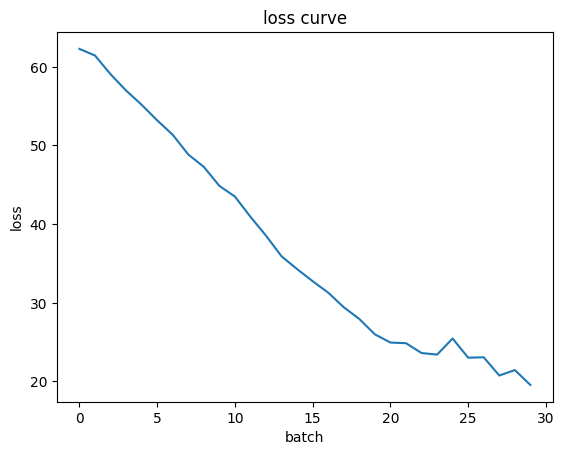

In [25]:
plt.plot(loss_record)
plt.xlabel("batch")
plt.ylabel("loss")
plt.title("loss curve")
plt.show()

In [38]:
import pickle
import pandas as pd

outfile = 'submission_resnet.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
preds = []

test_data = torch.load('data/testX.pt')
print(test_data[1].shape)
file_ids = test_data[-1]
rgb_data = test_data[0].to(device)

rgb_data = rgb_data.unsqueeze(1)
print(rgb_data.shape)

torch.Size([849, 3, 224, 224])
torch.Size([849, 1, 3, 3, 224, 224])


In [39]:
resnet18_model.eval()

for i, data in enumerate(rgb_data):
    # Please remember to modify this loop, input and output based on your model/architecture
    # normalize data[0]
    data[0] = (data[0] - data[0].mean()) / data[0].std()
    output = resnet18_model(data[0]) / 1000
    preds.append(output[0].cpu().detach().numpy())

df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file submission_resnet.csv
